# DOGE Patterned Dataset & ROI Analysis
## Prediksi Pencapaian ROI dan Potensi Profit Maksimum pada Trading Spot DOGE menggunakan K-Means Clustering dan Patterned Dataset Model

---

**Kerangka Metodologi:** CRISP-DM (Cross-Industry Standard Process for Data Mining)

**Adaptasi dari Paper:** *"Prediction of ROI Achievements and Potential Maximum Profit on Spot Bitcoin Rupiah Trading Using K-means Clustering and Patterned Dataset Model"*

---

### Struktur Notebook:
- **00 – Setup & Imports**
- **01 – Business Understanding**
- **02 – Data Understanding**
- **03 – Data Preparation (Patterned Dataset)**
- **04 – Modeling (K-means + ROI)**
- **05 – Evaluation & Conclusion**
- **06 – Deployment**

---
# 00 – Setup & Library Imports
---

In [35]:
# Cek versi Python & suppress warnings
import sys, warnings
warnings.filterwarnings("ignore")
print(f"Python Version: {sys.version}")

Python Version: 3.11.14 (main, Oct 21 2025, 18:31:21) [GCC 11.2.0]


In [36]:
# Import semua library yang dibutuhkan
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Machine Learning
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import (
    mutual_info_score, adjusted_mutual_info_score, normalized_mutual_info_score,
    rand_score, adjusted_rand_score, fowlkes_mallows_score,
    homogeneity_score, v_measure_score
)

# HTTP & progress
import requests
from tqdm import tqdm

# Untuk pickle model
import pickle

print("Semua library berhasil di-import")

Semua library berhasil di-import


In [37]:
# Definisi path untuk output
BASE_DIR = "/media/krisnaepras/Shared/Project/kuliah/datmin/fp3"
RAW_DATA_PATH = os.path.join(BASE_DIR, "data/raw")
PROCESSED_DATA_PATH = os.path.join(BASE_DIR, "data/processed")
FIGURES_PATH = os.path.join(BASE_DIR, "figures")
MODELS_PATH = os.path.join(BASE_DIR, "models")

# Pastikan folder sudah ada
for path in [RAW_DATA_PATH, PROCESSED_DATA_PATH, FIGURES_PATH, MODELS_PATH]:
    os.makedirs(path, exist_ok=True)
    
print(f"Base Directory   : {BASE_DIR}")
print(f"Raw Data         : {RAW_DATA_PATH}")
print(f"Processed Data   : {PROCESSED_DATA_PATH}")
print(f"Figures          : {FIGURES_PATH}")
print(f"Models           : {MODELS_PATH}")

Base Directory   : /media/krisnaepras/Shared/Project/kuliah/datmin/fp3
Raw Data         : /media/krisnaepras/Shared/Project/kuliah/datmin/fp3/data/raw
Processed Data   : /media/krisnaepras/Shared/Project/kuliah/datmin/fp3/data/processed
Figures          : /media/krisnaepras/Shared/Project/kuliah/datmin/fp3/figures
Models           : /media/krisnaepras/Shared/Project/kuliah/datmin/fp3/models


---
# 01 – Business Understanding
---

## 1.1 Ringkasan Paper Asli

Paper *"Prediction of ROI Achievements and Potential Maximum Profit on Spot Bitcoin Rupiah Trading Using K-means Clustering and Patterned Dataset Model"* memperkenalkan metode analisis trading cryptocurrency menggunakan:

1. **Patterned Dataset Model**: Transformasi data OHLC menjadi fitur-fitur pola harga seperti Range (R), Top Range (TR), Lower Range (LR), Percent Top Range (PTR), dan Percent Low Range (PLR).

2. **K-means Clustering**: Membagi data ke dalam cluster berdasarkan pola harga untuk mengidentifikasi kondisi pasar (Crash vs Moon).

3. **Diamond Crash Detection**: Mengidentifikasi momen ketika harga mendekati titik terendah harian (low) sebagai sinyal potensial untuk pembelian.

4. **ROI Calculation**: Menghitung potensi profit dalam jangka harian (D) dan bulanan (M) setelah kondisi Diamond Crash terdeteksi.

---

## 1.2 Adaptasi ke DOGE

Proyek ini mengadaptasi metodologi di atas untuk aset **DOGE (Dogecoin)** dengan karakteristik:

- **Aset**: DOGE/USDT (spot trading only, bukan futures/leverage)
- **Periode Data**: ±2-3 tahun terakhir hingga hari ini (30 November 2025)
- **Quote Currency**: USDT (karena likuiditas lebih tinggi dibanding IDR)

---

## 1.3 Pertanyaan Riset

1. **Apakah M ROI (Monthly ROI) secara konsisten lebih besar daripada D ROI (Daily ROI) pada DOGE seperti temuan pada Bitcoin?**

2. **Bagaimana frekuensi munculnya kondisi Diamond Crash pada DOGE per bulan?**

3. **Apakah strategi "beli saat Diamond Crash" lebih menguntungkan dibandingkan strategi buy & hold?**

---

## 1.4 Definisi Kunci

| Istilah | Definisi |
|---------|----------|
| **R (Range)** | Selisih harga tertinggi dan terendah harian: `H - L` |
| **TR (Top Range)** | Jarak dari harga tertinggi ke harga penutupan: `H - C` |
| **LR (Lower Range)** | Jarak dari harga penutupan ke harga terendah: `C - L` |
| **PTR (Percent Top Range)** | Persentase TR terhadap R: `(TR/R) × 100` |
| **PLR (Percent Low Range)** | Persentase LR terhadap R: `(LR/R) × 100` |
| **Crash** | Kondisi di mana harga mendekati low harian (PTR tinggi, PLR rendah) |
| **Moon** | Kondisi di mana harga mendekati high harian (PLR tinggi, PTR rendah) |
| **Diamond Crash** | Crash yang paling ekstrem (PTR di top 10%) – sinyal beli potensial |
| **D ROI** | Return on Investment dalam 24 jam setelah Diamond Crash |
| **M ROI** | Return on Investment dalam 1 bulan setelah Diamond Crash |

---
# 02 – Data Understanding
---

## 2.1 Data Acquisition

Mengambil data historical OHLCV DOGE/USDT dari **Binance API** dengan resolusi **hourly (1 jam)** untuk periode 2+ tahun terakhir.

**Sumber Data:** Binance REST API (klines endpoint)
- Endpoint: `https://api.binance.com/api/v3/klines`
- Symbol: `DOGEUSDT`
- Interval: `1h` (hourly)
- Limit: 1000 candles per request

In [38]:
def fetch_binance_ohlcv(symbol: str, interval: str, start_date: datetime, end_date: datetime) -> pd.DataFrame:
    """
    Mengambil data OHLCV dari Binance API.
    
    Parameters:
    -----------
    symbol : str
        Trading pair (e.g., 'DOGEUSDT')
    interval : str
        Candle interval (e.g., '1h', '1d')
    start_date : datetime
        Tanggal mulai
    end_date : datetime
        Tanggal akhir
        
    Returns:
    --------
    pd.DataFrame
        DataFrame dengan kolom: timestamp, open, high, low, close, volume
    """
    base_url = "https://api.binance.com/api/v3/klines"
    all_data = []
    
    # Convert to milliseconds
    start_ts = int(start_date.timestamp() * 1000)
    end_ts = int(end_date.timestamp() * 1000)
    
    current_start = start_ts
    
    print(f"Fetching {symbol} data from {start_date.date()} to {end_date.date()}...")
    
    with tqdm(total=(end_ts - start_ts) // (1000 * 3600 * 1000) + 1, desc="Downloading") as pbar:
        while current_start < end_ts:
            params = {
                'symbol': symbol,
                'interval': interval,
                'startTime': current_start,
                'endTime': end_ts,
                'limit': 1000
            }
            
            try:
                response = requests.get(base_url, params=params, timeout=30)
                response.raise_for_status()
                data = response.json()
                
                if not data:
                    break
                    
                all_data.extend(data)
                
                # Update start time untuk request berikutnya
                current_start = data[-1][0] + 1
                
                # Update progress
                pbar.update(len(data))
                
            except requests.exceptions.RequestException as e:
                print(f"Error fetching data: {e}")
                break
    
    if not all_data:
        return pd.DataFrame()
    
    # Convert to DataFrame
    df = pd.DataFrame(all_data, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_volume', 'trades', 'taker_buy_base',
        'taker_buy_quote', 'ignore'
    ])
    
    # Select dan convert kolom yang dibutuhkan
    df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']].copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    
    # Convert numeric columns
    for col in ['open', 'high', 'low', 'close', 'volume']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Remove duplicates
    df = df.drop_duplicates(subset=['timestamp']).sort_values('timestamp').reset_index(drop=True)
    
    print(f"Downloaded {len(df)} candles")
    
    return df

# Definisi periode data
END_DATE = datetime.now()
START_DATE = END_DATE - timedelta(days=2*365 + 180)  # ~2.5 tahun ke belakang

print(f"Periode Data: {START_DATE.date()} sampai {END_DATE.date()}")

Periode Data: 2023-06-04 sampai 2025-11-30


In [39]:
# Gunakan yfinance untuk mendapatkan data DOGE
import yfinance as yf

def fetch_doge_yfinance(start_date: datetime, end_date: datetime) -> pd.DataFrame:
    """
    Mengambil data OHLCV DOGE dari Yahoo Finance.
    
    Parameters:
    -----------
    start_date : datetime
        Tanggal mulai
    end_date : datetime
        Tanggal akhir
        
    Returns:
    --------
    pd.DataFrame
        DataFrame dengan kolom: timestamp, open, high, low, close, volume
    """
    print(f"Fetching DOGE-USD data from {start_date.date()} to {end_date.date()}...")
    
    # Fetch data DOGE-USD dari Yahoo Finance (interval 1h atau 1d)
    ticker = yf.Ticker("DOGE-USD")
    
    # Untuk data historical yang panjang, kita pakai interval daily
    # Karena yfinance hourly hanya tersedia untuk 730 hari terakhir
    df = ticker.history(start=start_date, end=end_date, interval="1d")
    
    if df.empty:
        print("No data returned from yfinance")
        return pd.DataFrame()
    
    # Reset index dan rename columns
    df = df.reset_index()
    df = df.rename(columns={
        'Date': 'timestamp',
        'Open': 'open',
        'High': 'high',
        'Low': 'low',
        'Close': 'close',
        'Volume': 'volume'
    })
    
    # Select kolom yang dibutuhkan
    df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']].copy()
    
    # Convert timestamp to datetime tanpa timezone
    df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_localize(None)
    
    # Remove duplicates
    df = df.drop_duplicates(subset=['timestamp']).sort_values('timestamp').reset_index(drop=True)
    
    print(f"Downloaded {len(df)} daily candles")
    return df

# Path untuk cache data
RAW_CSV_PATH = os.path.join(RAW_DATA_PATH, "doge_ohlc_daily.csv")

# Cek apakah cache valid sudah ada
if os.path.exists(RAW_CSV_PATH):
    try:
        df_raw = pd.read_csv(RAW_CSV_PATH, parse_dates=['timestamp'])
        if len(df_raw) > 0:
            print(f"Loading cached data from {RAW_CSV_PATH}...")
            print(f"Loaded {len(df_raw)} rows from cache")
        else:
            raise ValueError("Empty cache")
    except:
        os.remove(RAW_CSV_PATH)
        df_raw = None
else:
    df_raw = None

if df_raw is None:
    print("Fetching fresh data from Yahoo Finance...")
    df_raw = fetch_doge_yfinance(start_date=START_DATE, end_date=END_DATE)
    
    if len(df_raw) > 0:
        # Save to cache
        df_raw.to_csv(RAW_CSV_PATH, index=False)
        print(f"Data saved to {RAW_CSV_PATH}")
    else:
        print("Failed to fetch data!")

if len(df_raw) > 0:
    print(f"\nShape: {df_raw.shape}")
    print(f"Date Range: {df_raw['timestamp'].min()} to {df_raw['timestamp'].max()}")

Loading cached data from /media/krisnaepras/Shared/Project/kuliah/datmin/fp3/data/raw/doge_ohlc_daily.csv...
Loaded 909 rows from cache

Shape: (909, 6)
Date Range: 2023-06-04 00:00:00 to 2025-11-28 00:00:00


## 2.2 Exploratory Data Analysis (EDA)

Eksplorasi awal untuk memahami struktur dan karakteristik data DOGE/USD.

In [61]:
# Tampilkan informasi dasar dataset
print("="*60)
print("INFORMASI DATASET DOGE/USD")
print("="*60)

# Head (5 baris pertama)
print("\n1. Head (5 baris pertama):")
display(df_raw.head())

# Info ringkas
print("\n2. Info Dataset:")
info_df = pd.DataFrame({
    'Kolom': df_raw.columns,
    'Tipe Data': [str(df_raw[col].dtype) for col in df_raw.columns],
    'Non-Null Count': [df_raw[col].notna().sum() for col in df_raw.columns],
    'Null Count': [df_raw[col].isna().sum() for col in df_raw.columns]
})
display(info_df)

# Statistik Deskriptif
print("\n3. Statistik Deskriptif:")
display(df_raw.describe())

INFORMASI DATASET DOGE/USD

1. Head (5 baris pertama):


,timestamp,open,high,low,close,volume
0,2023-06-04,0.072672,0.073250,0.072466,0.072471,135558595
1,2023-06-05,0.072475,0.072632,0.064828,0.066573,506101788
2,2023-06-06,0.066568,0.071784,0.066112,0.070373,428926152
3,2023-06-07,0.070371,0.070371,0.066878,0.067300,278793457
4,2023-06-08,0.067302,0.068426,0.067154,0.067966,167825308



2. Info Dataset:


,Kolom,Tipe Data,Non-Null Count,Null Count
0,timestamp,datetime64[ns],909,0
1,open,float64,909,0
2,high,float64,909,0
3,low,float64,909,0
4,close,float64,909,0
5,volume,int64,909,0



3. Statistik Deskriptif:


,timestamp,open,high,low,close,volume
count,909,909.000000,909.000000,909.000000,909.000000,9.090000e+02
mean,2024-08-30 23:59:59.999999744,0.161542,0.167539,0.155542,0.161633,1.932203e+09
min,2023-06-04 00:00:00,0.057897,0.058495,0.057466,0.057897,9.248368e+07
25%,2024-01-17 00:00:00,0.085355,0.087061,0.083036,0.085543,4.985853e+08
50%,2024-08-31 00:00:00,0.152689,0.158759,0.145591,0.152689,1.093468e+09
75%,2025-04-15 00:00:00,0.201963,0.211239,0.195721,0.201963,2.295850e+09
max,2025-11-28 00:00:00,0.467299,0.483510,0.448240,0.467297,3.993647e+10
std,NaN,0.088806,0.093326,0.084462,0.088770,2.795678e+09


## 2.3 Data Quality Check

Pengecekan kualitas data: missing values, duplicate timestamps, dan anomali.

In [62]:
# Data Quality Check
print("="*60)
print("DATA QUALITY CHECK")
print("="*60)

# 1. Missing Values per Kolom
print("\n1. Missing Values per Kolom:")
missing_df = pd.DataFrame({
    'Kolom': df_raw.columns,
    'Missing Values': [df_raw[col].isnull().sum() for col in df_raw.columns],
    'Persentase': [f"{df_raw[col].isnull().sum()/len(df_raw)*100:.2f}%" for col in df_raw.columns]
})
display(missing_df)

# 2. Ringkasan Quality Check
print("\n2. Ringkasan Quality Check:")
duplicates = df_raw.duplicated(subset=['timestamp']).sum()
invalid_ohlc = (
    (df_raw['low'] > df_raw['close']) | 
    (df_raw['close'] > df_raw['high']) |
    (df_raw['low'] > df_raw['open']) |
    (df_raw['open'] > df_raw['high'])
).sum()

quality_df = pd.DataFrame({
    'Check': ['Duplicate Timestamps', 'Invalid OHLC', 'Negative/Zero Open', 
              'Negative/Zero High', 'Negative/Zero Low', 'Negative/Zero Close', 'Negative/Zero Volume'],
    'Jumlah': [
        duplicates, invalid_ohlc,
        (df_raw['open'] <= 0).sum(),
        (df_raw['high'] <= 0).sum(),
        (df_raw['low'] <= 0).sum(),
        (df_raw['close'] <= 0).sum(),
        (df_raw['volume'] <= 0).sum()
    ],
    'Status': [
        'OK' if duplicates == 0 else 'WARNING',
        'OK' if invalid_ohlc == 0 else 'WARNING',
        'OK' if (df_raw['open'] <= 0).sum() == 0 else 'WARNING',
        'OK' if (df_raw['high'] <= 0).sum() == 0 else 'WARNING',
        'OK' if (df_raw['low'] <= 0).sum() == 0 else 'WARNING',
        'OK' if (df_raw['close'] <= 0).sum() == 0 else 'WARNING',
        'OK' if (df_raw['volume'] <= 0).sum() == 0 else 'WARNING'
    ]
})
display(quality_df)

DATA QUALITY CHECK

1. Missing Values per Kolom:


,Kolom,Missing Values,Persentase
0,timestamp,0,0.00%
1,open,0,0.00%
2,high,0,0.00%
3,low,0,0.00%
4,close,0,0.00%
5,volume,0,0.00%



2. Ringkasan Quality Check:


,Check,Jumlah,Status
0,Duplicate Timestamps,0,OK
1,Invalid OHLC,0,OK
2,Negative/Zero Open,0,OK
3,Negative/Zero High,0,OK
4,Negative/Zero Low,0,OK
5,Negative/Zero Close,0,OK
6,Negative/Zero Volume,0,OK


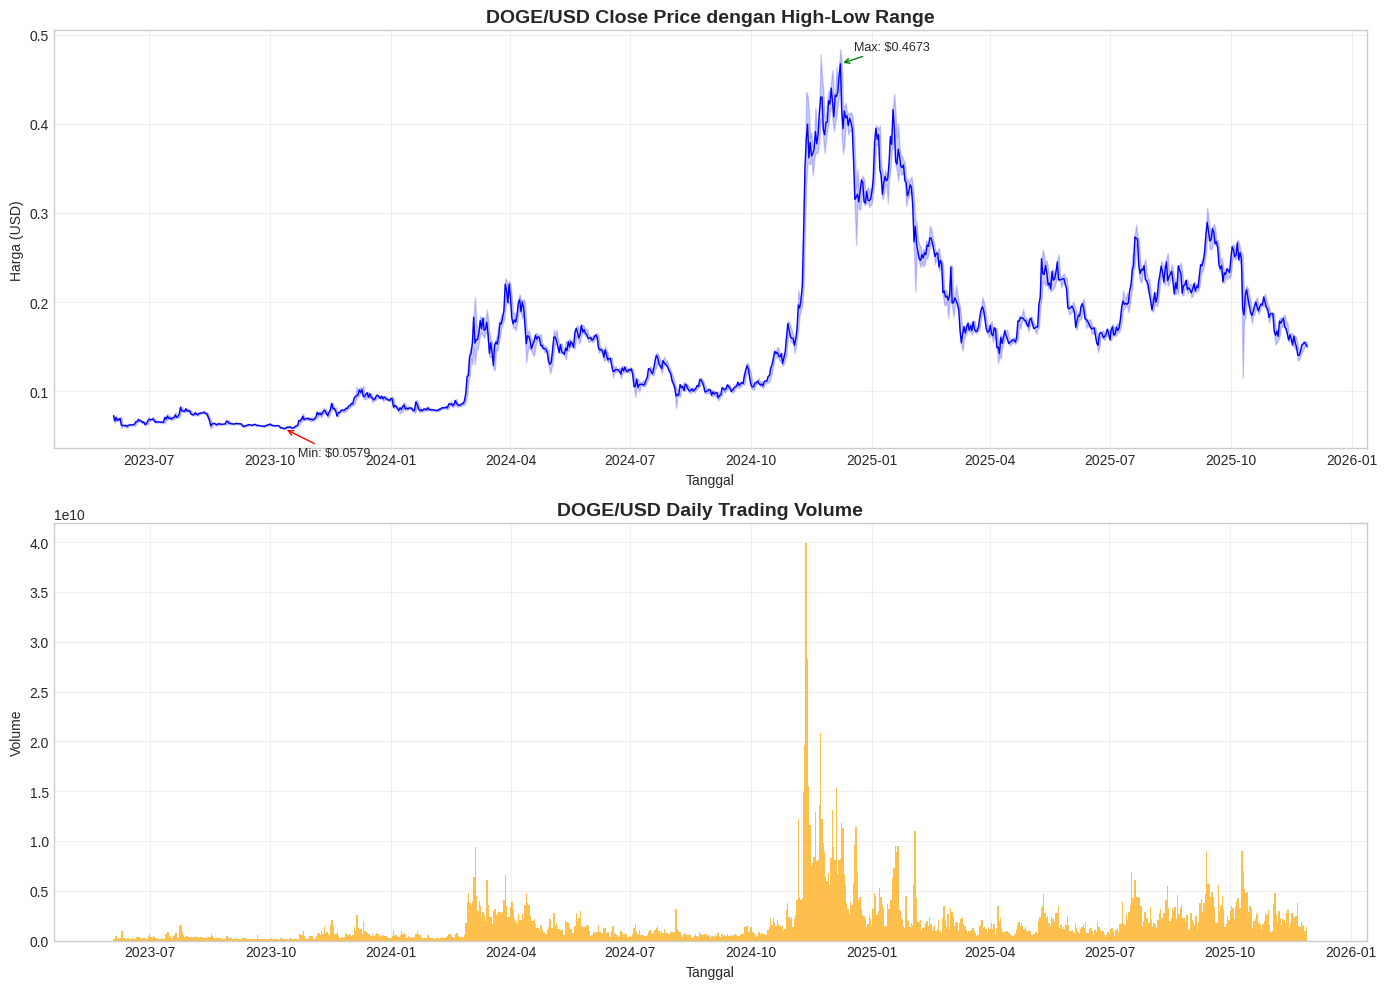


Grafik disimpan ke: /media/krisnaepras/Shared/Project/kuliah/datmin/fp3/figures/doge_price_volume_timeseries.png


In [42]:
# Visualisasi Time Series Harga DOGE
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Close Price
ax1 = axes[0]
ax1.plot(df_raw['timestamp'], df_raw['close'], color='blue', linewidth=1)
ax1.fill_between(df_raw['timestamp'], df_raw['low'], df_raw['high'], alpha=0.2, color='blue')
ax1.set_title('DOGE/USD Close Price dengan High-Low Range', fontsize=14, fontweight='bold')
ax1.set_xlabel('Tanggal')
ax1.set_ylabel('Harga (USD)')
ax1.grid(True, alpha=0.3)

# Tambahkan anotasi untuk high dan low
max_idx = df_raw['close'].idxmax()
min_idx = df_raw['close'].idxmin()
ax1.annotate(f'Max: ${df_raw.loc[max_idx, "close"]:.4f}', 
             xy=(df_raw.loc[max_idx, 'timestamp'], df_raw.loc[max_idx, 'close']),
             xytext=(10, 10), textcoords='offset points', fontsize=9,
             arrowprops=dict(arrowstyle='->', color='green'))
ax1.annotate(f'Min: ${df_raw.loc[min_idx, "close"]:.4f}', 
             xy=(df_raw.loc[min_idx, 'timestamp'], df_raw.loc[min_idx, 'close']),
             xytext=(10, -20), textcoords='offset points', fontsize=9,
             arrowprops=dict(arrowstyle='->', color='red'))

# Plot 2: Volume
ax2 = axes[1]
ax2.bar(df_raw['timestamp'], df_raw['volume'], color='orange', alpha=0.7, width=1)
ax2.set_title('DOGE/USD Daily Trading Volume', fontsize=14, fontweight='bold')
ax2.set_xlabel('Tanggal')
ax2.set_ylabel('Volume')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, 'doge_price_volume_timeseries.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\nGrafik disimpan ke: {FIGURES_PATH}/doge_price_volume_timeseries.png")

---
# 03 – Data Preparation (Patterned Dataset Model)
---

## 3.1 Patterned Dataset Feature Engineering

Menghitung fitur-fitur Patterned Dataset sesuai paper:

- **R (Range)**: `H - L` → Jarak antara harga tertinggi dan terendah harian
- **TR (Top Range)**: `H - C` → Jarak dari high ke close
- **LR (Lower Range)**: `C - L` → Jarak dari close ke low
- **PTR (Percent Top Range)**: `(TR / R) × 100` → Persentase TR terhadap R
- **PLR (Percent Low Range)**: `(LR / R) × 100` → Persentase LR terhadap R

**Interpretasi:**
- **PTR tinggi, PLR rendah** → Harga close mendekati low (kondisi **CRASH**)
- **PLR tinggi, PTR rendah** → Harga close mendekati high (kondisi **MOON**)

In [63]:
# Buat copy DataFrame untuk Patterned Dataset
df_patterned = df_raw.copy()

# Rename kolom untuk konsistensi dengan paper
df_patterned = df_patterned.rename(columns={
    'high': 'H',
    'low': 'L',
    'close': 'C',
    'open': 'O',
    'volume': 'V'
})

# Hitung fitur Patterned Dataset sesuai paper
# R = Range = High - Low
df_patterned['R'] = df_patterned['H'] - df_patterned['L']

# TR = Top Range = High - Close
df_patterned['TR'] = df_patterned['H'] - df_patterned['C']

# LR = Lower Range = Close - Low
df_patterned['LR'] = df_patterned['C'] - df_patterned['L']

# PTR = Percent Top Range = (TR / R) * 100
# Hindari division by zero dengan np.where
df_patterned['PTR'] = np.where(
    df_patterned['R'] > 0,
    (df_patterned['TR'] / df_patterned['R']) * 100,
    0
)

# PLR = Percent Low Range = (LR / R) * 100
df_patterned['PLR'] = np.where(
    df_patterned['R'] > 0,
    (df_patterned['LR'] / df_patterned['R']) * 100,
    0
)

print("="*60)
print("PATTERNED DATASET FEATURES")
print("="*60)

# Head dengan fitur baru
print("\n1. Data dengan Fitur Patterned (10 baris pertama):")
display(df_patterned[['timestamp', 'H', 'L', 'C', 'R', 'TR', 'LR', 'PTR', 'PLR']].head(10))

# Statistik Fitur Patterned Dataset
print("\n2. Statistik Fitur Patterned Dataset:")
display(df_patterned[['R', 'TR', 'LR', 'PTR', 'PLR']].describe())

PATTERNED DATASET FEATURES

1. Data dengan Fitur Patterned (10 baris pertama):


,timestamp,H,L,C,R,TR,LR,PTR,PLR
0,2023-06-04,0.073250,0.072466,0.072471,0.000784,0.000779,0.000005,99.362331,0.637669
1,2023-06-05,0.072632,0.064828,0.066573,0.007804,0.006059,0.001745,77.639663,22.360337
2,2023-06-06,0.071784,0.066112,0.070373,0.005672,0.001411,0.004261,24.876557,75.123443
3,2023-06-07,0.070371,0.066878,0.067300,0.003493,0.003071,0.000422,87.918681,12.081319
4,2023-06-08,0.068426,0.067154,0.067966,0.001272,0.000460,0.000812,36.163421,63.836579
5,2023-06-09,0.070920,0.067626,0.069489,0.003294,0.001431,0.001863,43.442514,56.557486
6,2023-06-10,0.070591,0.058536,0.061860,0.012055,0.008731,0.003324,72.426398,27.573602
7,2023-06-11,0.062515,0.061303,0.061587,0.001212,0.000928,0.000284,76.567807,23.432193
8,2023-06-12,0.061635,0.060404,0.061459,0.001231,0.000176,0.001055,14.297128,85.702872
9,2023-06-13,0.062453,0.060764,0.061723,0.001689,0.000730,0.000959,43.220817,56.779183



2. Statistik Fitur Patterned Dataset:


,R,TR,LR,PTR,PLR
count,909.000000,909.000000,909.000000,909.000000,909.000000
mean,0.011996,0.005905,0.006091,48.797531,51.202469
std,0.012987,0.008090,0.008372,29.662043,29.662043
min,0.000468,0.000000,0.000000,0.000000,0.000000
25%,0.003854,0.001083,0.001243,21.422054,25.395894
50%,0.008280,0.003021,0.003186,50.186241,49.813759
75%,0.015295,0.007783,0.007879,74.604106,78.577946
max,0.138840,0.060469,0.078371,100.000000,100.000000


In [44]:
# Validasi rumus PTR + PLR = 100 (harus selalu true)
df_patterned['check_sum'] = df_patterned['PTR'] + df_patterned['PLR']
print("Validasi: PTR + PLR harus = 100")
print(f"   Min : {df_patterned['check_sum'].min():.6f}")
print(f"   Max : {df_patterned['check_sum'].max():.6f}")
print(f"   Mean: {df_patterned['check_sum'].mean():.6f}")

# Hapus kolom check
df_patterned = df_patterned.drop(columns=['check_sum'])

print("\nRumus tervalidasi - PTR + PLR selalu = 100")

Validasi: PTR + PLR harus = 100
   Min : 100.000000
   Max : 100.000000
   Mean: 100.000000

Rumus tervalidasi - PTR + PLR selalu = 100


## 3.2 Klasifikasi Kondisi: Crash, Moon, Neutral

Berdasarkan paper, kondisi pasar dikategorikan sebagai:

| Kondisi | Kriteria | Interpretasi |
|---------|----------|--------------|
| **CRASH** | PTR ≥ 90% dan PLR ≤ 10% | Harga close sangat dekat dengan low harian |
| **MOON** | PLR ≥ 90% dan PTR ≤ 10% | Harga close sangat dekat dengan high harian |
| **NEUTRAL** | Lainnya | Harga close di tengah-tengah range |

*Catatan: Threshold 90%/10% dipilih sebagai nilai yang lebih realistis untuk DOGE dibanding 95%/5% di paper*

In [64]:
# Definisi threshold untuk kondisi Crash dan Moon
CRASH_THRESHOLD_PTR = 90  # PTR >= 90%
CRASH_THRESHOLD_PLR = 10  # PLR <= 10%
MOON_THRESHOLD_PLR = 90   # PLR >= 90%
MOON_THRESHOLD_PTR = 10   # PTR <= 10%

def classify_condition(row):
    """
    Klasifikasi kondisi pasar berdasarkan PTR dan PLR.
    
    Returns:
    --------
    str: 'crash', 'moon', atau 'neutral'
    """
    if row['PTR'] >= CRASH_THRESHOLD_PTR and row['PLR'] <= CRASH_THRESHOLD_PLR:
        return 'crash'
    elif row['PLR'] >= MOON_THRESHOLD_PLR and row['PTR'] <= MOON_THRESHOLD_PTR:
        return 'moon'
    else:
        return 'neutral'

# Terapkan klasifikasi
df_patterned['condition'] = df_patterned.apply(classify_condition, axis=1)

# Tampilkan distribusi kondisi
print("="*60)
print("DISTRIBUSI KONDISI PASAR")
print("="*60)

condition_counts = df_patterned['condition'].value_counts()

# Buat DataFrame untuk distribusi
print("\n1. Jumlah per Kondisi:")
distribusi_df = pd.DataFrame({
    'Kondisi': [cond.upper() for cond in condition_counts.index],
    'Jumlah': condition_counts.values,
    'Persentase': [f"{count/len(df_patterned)*100:.2f}%" for count in condition_counts.values]
})
display(distribusi_df)

# Tampilkan total
print(f"\nTotal: {len(df_patterned)} hari")

DISTRIBUSI KONDISI PASAR

1. Jumlah per Kondisi:


,Kondisi,Jumlah,Persentase
0,NEUTRAL,723,79.54%
1,MOON,100,11.00%
2,CRASH,86,9.46%



Total: 909 hari


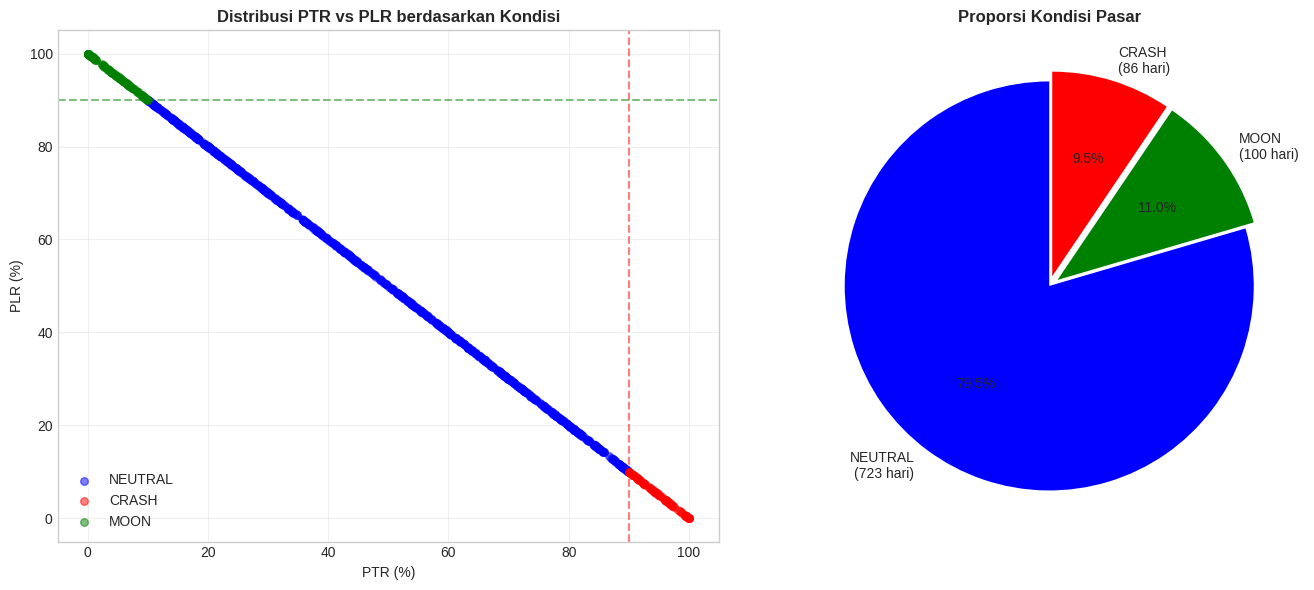


Grafik disimpan ke: /media/krisnaepras/Shared/Project/kuliah/datmin/fp3/figures/ptr_plr_distribution.png


In [46]:
# Visualisasi distribusi PTR vs PLR dengan kondisi
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Color mapping
colors = {'crash': 'red', 'moon': 'green', 'neutral': 'blue'}

# Plot 1: Scatter PTR vs PLR
ax1 = axes[0]
for cond in ['neutral', 'crash', 'moon']:
    mask = df_patterned['condition'] == cond
    ax1.scatter(
        df_patterned.loc[mask, 'PTR'],
        df_patterned.loc[mask, 'PLR'],
        c=colors[cond],
        label=cond.upper(),
        alpha=0.5,
        s=30
    )
ax1.set_xlabel('PTR (%)')
ax1.set_ylabel('PLR (%)')
ax1.set_title('Distribusi PTR vs PLR berdasarkan Kondisi', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Tambahkan garis threshold
ax1.axvline(x=CRASH_THRESHOLD_PTR, color='red', linestyle='--', alpha=0.5, label='Crash Threshold')
ax1.axhline(y=MOON_THRESHOLD_PLR, color='green', linestyle='--', alpha=0.5, label='Moon Threshold')

# Plot 2: Pie Chart distribusi
ax2 = axes[1]
condition_counts = df_patterned['condition'].value_counts()
ax2.pie(
    condition_counts.values,
    labels=[f"{cond.upper()}\n({count} hari)" for cond, count in condition_counts.items()],
    colors=[colors.get(cond, 'gray') for cond in condition_counts.index],
    autopct='%1.1f%%',
    startangle=90,
    explode=[0.05 if cond != 'neutral' else 0 for cond in condition_counts.index]
)
ax2.set_title('Proporsi Kondisi Pasar', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, 'ptr_plr_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\nGrafik disimpan ke: {FIGURES_PATH}/ptr_plr_distribution.png")

## 3.3 Patterned Dataset Variants

Membuat tiga varian dataset untuk perbandingan analisis clustering:

1. **df_complete**: Semua data (909 baris)
2. **df_crash**: Hanya data kondisi CRASH (86 baris)
3. **df_moon**: Hanya data kondisi MOON (100 baris)

In [65]:
# Buat dataset variants
df_complete = df_patterned.copy()
df_crash = df_patterned[df_patterned['condition'] == 'crash'].copy().reset_index(drop=True)
df_moon = df_patterned[df_patterned['condition'] == 'moon'].copy().reset_index(drop=True)

print("="*60)
print("PATTERNED DATASET VARIANTS")
print("="*60)

# Buat tabel ringkasan dataset variants
variants_df = pd.DataFrame({
    'Dataset': ['df_complete', 'df_crash', 'df_moon'],
    'Jumlah Baris': [len(df_complete), len(df_crash), len(df_moon)],
    'Deskripsi': ['Semua data', 'Kondisi CRASH saja', 'Kondisi MOON saja'],
    'File Output': ['doge_patterned_complete.csv', 'doge_patterned_crash.csv', 'doge_patterned_moon.csv']
})
display(variants_df)

# Simpan ke file processed
df_complete.to_csv(os.path.join(PROCESSED_DATA_PATH, 'doge_patterned_complete.csv'), index=False)
df_crash.to_csv(os.path.join(PROCESSED_DATA_PATH, 'doge_patterned_crash.csv'), index=False)
df_moon.to_csv(os.path.join(PROCESSED_DATA_PATH, 'doge_patterned_moon.csv'), index=False)

print(f"\nDataset disimpan ke: {PROCESSED_DATA_PATH}")

PATTERNED DATASET VARIANTS


,Dataset,Jumlah Baris,Deskripsi,File Output
0,df_complete,909,Semua data,doge_patterned_complete.csv
1,df_crash,86,Kondisi CRASH saja,doge_patterned_crash.csv
2,df_moon,100,Kondisi MOON saja,doge_patterned_moon.csv



Dataset disimpan ke: /media/krisnaepras/Shared/Project/kuliah/datmin/fp3/data/processed


---
# 04 – Modeling
---

## 4.1 K-means Clustering pada Patterned Dataset

Tujuan: Menguji kualitas clustering pada tiga varian dataset (Complete, Crash, Moon) menggunakan K-means dengan K=2 cluster.

**Fitur yang digunakan untuk clustering:** `[R, TR, LR, PTR, PLR]`

**Metrik evaluasi clustering:**
- Mutual Information Score
- Adjusted Mutual Information Score
- Normalized Mutual Information Score  
- Rand Score
- Adjusted Rand Score
- Fowlkes-Mallows Score
- Homogeneity Score
- V-Measure Score

In [66]:
# Feature selection untuk clustering
CLUSTER_FEATURES = ['R', 'TR', 'LR', 'PTR', 'PLR']

# Fungsi untuk melakukan K-means clustering dan menghitung metrik
def perform_kmeans_analysis(df, name, n_clusters=2, random_state=42):
    """
    Melakukan K-means clustering dan menghitung metrik evaluasi.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame dengan fitur untuk clustering
    name : str
        Nama dataset
    n_clusters : int
        Jumlah cluster
    random_state : int
        Random state untuk reproducibility
        
    Returns:
    --------
    dict : Dictionary berisi hasil clustering dan metrik
    """
    if len(df) < n_clusters:
        print(f"{name}: Tidak cukup data untuk {n_clusters} cluster")
        return None
    
    # Extract fitur dan scaling
    X = df[CLUSTER_FEATURES].values
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    # K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Buat true labels dari condition (untuk metrik yang butuh ground truth)
    # Untuk complete dataset, kita pakai kondisi sebagai label
    # Untuk crash/moon, kita buat binary label berdasarkan median PTR
    if 'condition' in df.columns:
        # Map kondisi ke numeric untuk metrik
        condition_map = {'crash': 0, 'moon': 1, 'neutral': 2}
        true_labels = df['condition'].map(condition_map).values
        # Untuk metrik yang butuh binary, kita simplify
        true_labels_binary = (df['PTR'] > df['PTR'].median()).astype(int).values
    else:
        true_labels_binary = (df['PTR'] > df['PTR'].median()).astype(int).values
    
    # Hitung metrik clustering
    metrics = {
        'dataset': name,
        'n_samples': len(df),
        'mutual_info_score': mutual_info_score(true_labels_binary, cluster_labels),
        'adjusted_mutual_info': adjusted_mutual_info_score(true_labels_binary, cluster_labels),
        'normalized_mutual_info': normalized_mutual_info_score(true_labels_binary, cluster_labels),
        'rand_score': rand_score(true_labels_binary, cluster_labels),
        'adjusted_rand_score': adjusted_rand_score(true_labels_binary, cluster_labels),
        'fowlkes_mallows': fowlkes_mallows_score(true_labels_binary, cluster_labels),
        'homogeneity': homogeneity_score(true_labels_binary, cluster_labels),
        'v_measure': v_measure_score(true_labels_binary, cluster_labels)
    }
    
    return {
        'metrics': metrics,
        'cluster_labels': cluster_labels,
        'kmeans': kmeans,
        'scaler': scaler,
        'X_scaled': X_scaled
    }

print("Fungsi clustering siap digunakan")

Fungsi clustering siap digunakan


In [67]:
# Jalankan K-means pada semua dataset variants
print("="*60)
print("K-MEANS CLUSTERING ANALYSIS")
print("="*60)

datasets = {
    'Complete': df_complete,
    'Crash': df_crash,
    'Moon': df_moon
}

clustering_results = {}
all_metrics = []

for name, df in datasets.items():
    print(f"\nProcessing: {name} ({len(df)} samples)")
    result = perform_kmeans_analysis(df, name)
    
    if result:
        clustering_results[name] = result
        all_metrics.append(result['metrics'])
        
        # Tambahkan cluster labels ke dataframe asli
        if name == 'Complete':
            df_complete['cluster'] = result['cluster_labels']
        elif name == 'Crash':
            df_crash['cluster'] = result['cluster_labels']
        elif name == 'Moon':
            df_moon['cluster'] = result['cluster_labels']

print("\nClustering selesai untuk semua dataset")

K-MEANS CLUSTERING ANALYSIS

Processing: Complete (909 samples)

Processing: Crash (86 samples)

Processing: Moon (100 samples)

Clustering selesai untuk semua dataset


In [68]:
# Tampilkan tabel perbandingan metrik clustering
df_metrics = pd.DataFrame(all_metrics)
df_metrics = df_metrics.set_index('dataset')

print("="*60)
print("PERBANDINGAN METRIK CLUSTERING")
print("="*60)

# Tampilkan tabel metrik
metric_columns = [
    'n_samples', 'mutual_info_score', 'adjusted_mutual_info', 
    'normalized_mutual_info', 'rand_score', 'adjusted_rand_score',
    'fowlkes_mallows', 'homogeneity', 'v_measure'
]

print("\n1. Metrik Clustering per Dataset:")
display(df_metrics[metric_columns].T.round(4))

# Hitung rata-rata skor untuk tiap dataset (tanpa n_samples)
score_columns = [c for c in metric_columns if c != 'n_samples']
df_metrics['avg_score'] = df_metrics[score_columns].mean(axis=1)

# Buat tabel rata-rata skor
print("\n2. Rata-rata Skor per Dataset:")
avg_score_df = pd.DataFrame({
    'Dataset': df_metrics.index,
    'Avg Score': [f"{df_metrics.loc[idx, 'avg_score']:.4f}" for idx in df_metrics.index],
    'Ranking': [1 if idx == df_metrics['avg_score'].idxmax() else 
                (2 if df_metrics.loc[idx, 'avg_score'] == df_metrics['avg_score'].nlargest(2).iloc[-1] else 3) 
                for idx in df_metrics.index]
})
display(avg_score_df)

PERBANDINGAN METRIK CLUSTERING

1. Metrik Clustering per Dataset:


dataset,Complete,Crash,Moon
n_samples,909.0000,86.0000,100.0000
mutual_info_score,0.6443,0.5341,0.5256
adjusted_mutual_info,0.9296,0.7710,0.7593
normalized_mutual_info,0.9297,0.7729,0.7610
rand_score,0.9804,0.9103,0.9040
adjusted_rand_score,0.9607,0.8205,0.8081
fowlkes_mallows,0.9804,0.9096,0.9036
homogeneity,0.9296,0.7705,0.7583
v_measure,0.9297,0.7729,0.7610



2. Rata-rata Skor per Dataset:


,Dataset,Avg Score,Ranking
0,Complete,0.9105,1
1,Crash,0.7827,2
2,Moon,0.7726,3


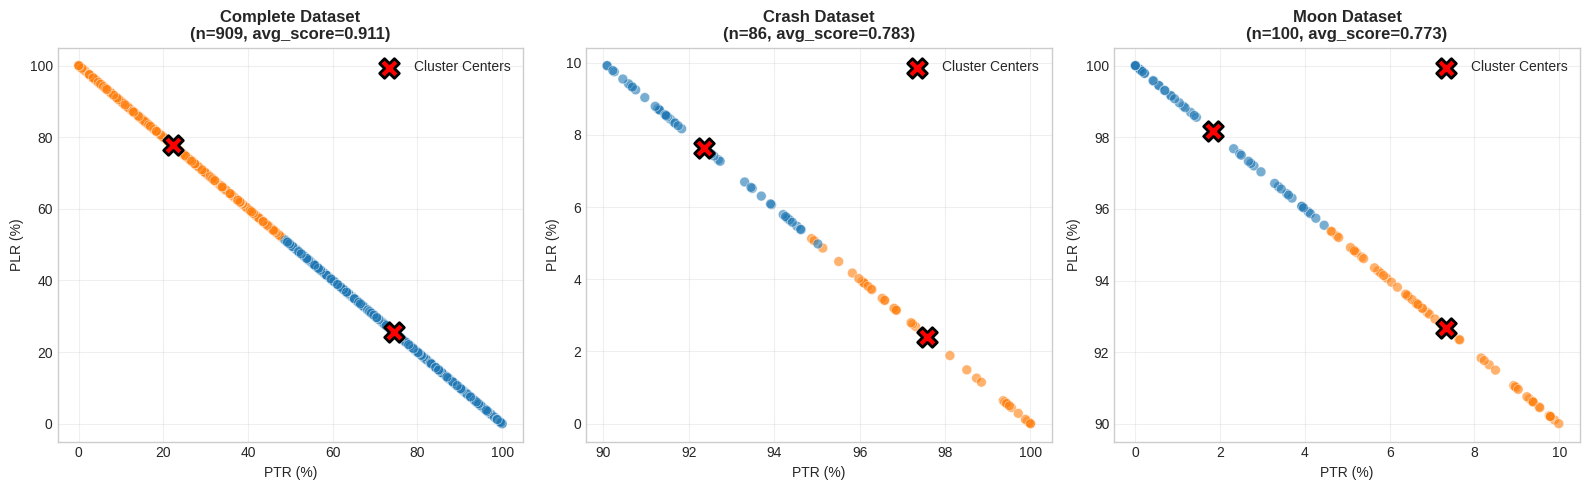


Grafik disimpan ke: /media/krisnaepras/Shared/Project/kuliah/datmin/fp3/figures/kmeans_clustering_comparison.png


In [51]:
# Visualisasi hasil clustering untuk tiap dataset
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

datasets_plot = [
    ('Complete', df_complete, clustering_results['Complete']),
    ('Crash', df_crash, clustering_results['Crash']),
    ('Moon', df_moon, clustering_results['Moon'])
]

cluster_colors = ['#1f77b4', '#ff7f0e']  # Blue, Orange

for ax, (name, df, result) in zip(axes, datasets_plot):
    X_scaled = result['X_scaled']
    labels = result['cluster_labels']
    
    # Plot PTR vs PLR (scaled)
    scatter = ax.scatter(
        df['PTR'], df['PLR'],
        c=[cluster_colors[l] for l in labels],
        alpha=0.6, s=50, edgecolors='white', linewidths=0.5
    )
    
    # Plot cluster centers (unscale untuk PTR dan PLR)
    centers = result['kmeans'].cluster_centers_
    scaler = result['scaler']
    centers_unscaled = scaler.inverse_transform(centers)
    
    ax.scatter(
        centers_unscaled[:, 3], centers_unscaled[:, 4],  # PTR dan PLR
        c='red', marker='X', s=200, edgecolors='black', linewidths=2,
        label='Cluster Centers'
    )
    
    ax.set_xlabel('PTR (%)')
    ax.set_ylabel('PLR (%)')
    ax.set_title(f'{name} Dataset\n(n={len(df)}, avg_score={df_metrics.loc[name, "avg_score"]:.3f})',
                 fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, 'kmeans_clustering_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\nGrafik disimpan ke: {FIGURES_PATH}/kmeans_clustering_comparison.png")

## 4.2 Diamond Crash Detection & ROI Calculation

**Diamond Crash** adalah kondisi ekstrem dimana harga DOGE sangat dekat dengan low harian, yang dianggap sebagai sinyal potensial untuk pembelian.

**Kriteria Diamond Crash:**
- Kondisi = "crash" (PTR ≥ 90%, PLR ≤ 10%)
- PTR berada di **top 10%** dari seluruh data (kondisi crash paling ekstrem)

**Perhitungan ROI:**
- **D ROI (Daily)**: Potensi profit maksimum dalam 24 jam setelah Diamond Crash
- **M ROI (Monthly)**: Potensi profit maksimum sampai akhir bulan setelah Diamond Crash

In [69]:
# Identifikasi Diamond Crash Events
# Diamond Crash = Crash condition dengan PTR di top 10%

# Hitung percentile PTR
ptr_90_percentile = df_complete['PTR'].quantile(0.90)

print("="*60)
print("DIAMOND CRASH DETECTION")
print("="*60)

# Tabel parameter
print("\n1. Parameter Diamond Crash:")
param_df = pd.DataFrame({
    'Parameter': ['PTR 90th Percentile', 'Kondisi', 'Kriteria'],
    'Nilai': [f"{ptr_90_percentile:.2f}%", 'crash', f"PTR >= {ptr_90_percentile:.2f}%"]
})
display(param_df)

# Filter Diamond Crash: condition='crash' DAN PTR >= 90th percentile
df_diamond_crash = df_complete[
    (df_complete['condition'] == 'crash') & 
    (df_complete['PTR'] >= ptr_90_percentile)
].copy()

# Tabel ringkasan
print("\n2. Ringkasan Diamond Crash:")
dc_summary = pd.DataFrame({
    'Metric': ['Total Diamond Crash Events', 'Total Crash Events', 'Persentase DC dari Crash'],
    'Nilai': [len(df_diamond_crash), len(df_crash), f"{len(df_diamond_crash)/len(df_crash)*100:.1f}%"]
})
display(dc_summary)

# Tampilkan contoh Diamond Crash events
print("\n3. Contoh Diamond Crash Events (5 pertama):")
display(df_diamond_crash[['timestamp', 'C', 'PTR', 'PLR']].head())

DIAMOND CRASH DETECTION

1. Parameter Diamond Crash:


,Parameter,Nilai
0,PTR 90th Percentile,89.52%
1,Kondisi,crash
2,Kriteria,PTR >= 89.52%



2. Ringkasan Diamond Crash:


,Metric,Nilai
0,Total Diamond Crash Events,86
1,Total Crash Events,86
2,Persentase DC dari Crash,100.0%



3. Contoh Diamond Crash Events (5 pertama):


,timestamp,C,PTR,PLR
0,2023-06-04,0.072471,99.362331,0.637669
18,2023-06-22,0.065643,97.309084,2.690916
32,2023-07-06,0.065026,99.394896,0.605104
42,2023-07-16,0.069554,94.334731,5.665269
59,2023-08-02,0.074213,97.240644,2.759356


In [70]:
# Buat DataFrame untuk menyimpan DC events dengan info ROI
dc_events = []

# Set index timestamp untuk lookup cepat
df_complete_indexed = df_complete.set_index('timestamp')

for idx, row in df_diamond_crash.iterrows():
    dc_date = row['timestamp']
    dc_price = row['C']  # Harga close saat Diamond Crash (harga beli)
    dc_month = dc_date.to_period('M')
    
    # ===== D ROI (Daily): Max price dalam 24 jam ke depan =====
    d_end_date = dc_date + timedelta(days=1)
    
    # Filter data 24 jam ke depan
    mask_d = (df_complete['timestamp'] > dc_date) & (df_complete['timestamp'] <= d_end_date)
    df_next_day = df_complete[mask_d]
    
    if len(df_next_day) > 0:
        d_max_price = df_next_day['H'].max()  # Harga tertinggi dalam 24 jam
        d_max_date = df_next_day.loc[df_next_day['H'].idxmax(), 'timestamp']
    else:
        d_max_price = dc_price
        d_max_date = dc_date
    
    d_profit = d_max_price - dc_price
    d_roi = (d_profit / dc_price) * 100 if dc_price > 0 else 0
    
    # ===== M ROI (Monthly): Max price sampai akhir bulan =====
    # Akhir bulan
    m_end_date = dc_date + pd.offsets.MonthEnd(0)
    
    # Filter data sampai akhir bulan
    mask_m = (df_complete['timestamp'] > dc_date) & (df_complete['timestamp'] <= m_end_date)
    df_month_end = df_complete[mask_m]
    
    if len(df_month_end) > 0:
        m_max_price = df_month_end['H'].max()  # Harga tertinggi sampai akhir bulan
        m_max_date = df_month_end.loc[df_month_end['H'].idxmax(), 'timestamp']
    else:
        m_max_price = dc_price
        m_max_date = dc_date
    
    m_profit = m_max_price - dc_price
    m_roi = (m_profit / dc_price) * 100 if dc_price > 0 else 0
    
    dc_events.append({
        'dc_date': dc_date,
        'year_month': str(dc_month),
        'dc_price': dc_price,
        'ptr': row['PTR'],
        # Daily ROI
        'd_max_price': d_max_price,
        'd_max_date': d_max_date,
        'd_profit': d_profit,
        'd_roi': d_roi,
        # Monthly ROI
        'm_max_price': m_max_price,
        'm_max_date': m_max_date,
        'm_profit': m_profit,
        'm_roi': m_roi
    })

df_dc_events = pd.DataFrame(dc_events)

print("="*60)
print("DIAMOND CRASH EVENTS WITH ROI")
print("="*60)

print(f"\nTotal Events: {len(df_dc_events)}")

print("\n1. Contoh Events (10 pertama):")
display(df_dc_events[['dc_date', 'dc_price', 'd_roi', 'm_roi']].head(10))

DIAMOND CRASH EVENTS WITH ROI

Total Events: 86

1. Contoh Events (10 pertama):


,dc_date,dc_price,d_roi,m_roi
0,2023-06-04,0.072471,0.222157,0.222157
1,2023-06-22,0.065643,6.124043,6.124043
2,2023-07-06,0.065026,1.185681,28.165660
3,2023-07-16,0.069554,4.597863,19.822010
4,2023-08-02,0.074213,0.916281,3.957533
5,2023-08-06,0.074266,1.615811,3.883339
6,2023-08-15,0.070863,0.357026,0.357026
7,2023-08-16,0.067183,1.589682,1.589682
8,2023-09-21,0.061346,0.787342,1.890913
9,2023-09-24,0.060743,0.752350,2.902388


In [71]:
# Agregasi per bulan - seperti Table VI di paper
df_monthly_roi = df_dc_events.groupby('year_month').agg({
    'd_profit': 'sum',
    'd_roi': 'sum',
    'm_profit': 'sum',
    'm_roi': 'sum',
    'dc_date': 'count'  # Total DC events per bulan
}).rename(columns={'dc_date': 't_dc'})

# Hitung rata-rata ROI per DC event dalam bulan tersebut
df_monthly_roi['d_roi_avg'] = df_monthly_roi['d_roi'] / df_monthly_roi['t_dc']
df_monthly_roi['m_roi_avg'] = df_monthly_roi['m_roi'] / df_monthly_roi['t_dc']

# Reset index
df_monthly_roi = df_monthly_roi.reset_index()

print("="*70)
print("RINGKASAN ROI BULANAN (TABLE VI ADAPTATION)")
print("="*70)

# Tampilkan tabel bulanan
print("\n1. ROI per Bulan:")
display_df = df_monthly_roi[['year_month', 't_dc', 'd_profit', 'd_roi', 'm_profit', 'm_roi']].copy()
display_df['d_profit'] = display_df['d_profit'].apply(lambda x: f"{x:.6f}")
display_df['m_profit'] = display_df['m_profit'].apply(lambda x: f"{x:.6f}")
display_df['d_roi'] = display_df['d_roi'].apply(lambda x: f"{x:.2f}%")
display_df['m_roi'] = display_df['m_roi'].apply(lambda x: f"{x:.2f}%")
display_df.columns = ['Year-Month', 'DC Events', 'D Profit', 'D ROI', 'M Profit', 'M ROI']
display(display_df)

# Statistik ringkasan
print("\n2. Statistik Ringkasan:")
stats_df = pd.DataFrame({
    'Metric': [
        'Periode', 'Total Bulan dengan DC Events', 'Total Diamond Crash Events',
        'D ROI - Total', 'D ROI - Rata-rata per bulan', 'D ROI - Rata-rata per event',
        'M ROI - Total', 'M ROI - Rata-rata per bulan', 'M ROI - Rata-rata per event',
        'Rasio M ROI / D ROI'
    ],
    'Nilai': [
        f"{df_monthly_roi['year_month'].min()} - {df_monthly_roi['year_month'].max()}",
        len(df_monthly_roi),
        df_monthly_roi['t_dc'].sum(),
        f"{df_monthly_roi['d_roi'].sum():.2f}%",
        f"{df_monthly_roi['d_roi'].mean():.2f}%",
        f"{df_dc_events['d_roi'].mean():.2f}%",
        f"{df_monthly_roi['m_roi'].sum():.2f}%",
        f"{df_monthly_roi['m_roi'].mean():.2f}%",
        f"{df_dc_events['m_roi'].mean():.2f}%",
        f"{df_monthly_roi['m_roi'].sum() / df_monthly_roi['d_roi'].sum():.2f}x"
    ]
})
display(stats_df)

RINGKASAN ROI BULANAN (TABLE VI ADAPTATION)

1. ROI per Bulan:


,Year-Month,DC Events,D Profit,D ROI,M Profit,M ROI
0,2023-06,2,0.004181,6.35%,0.004181,6.35%
1,2023-07,2,0.003969,5.78%,0.032102,47.99%
2,2023-08,4,0.003201,4.48%,0.007142,9.79%
3,2023-09,2,0.000940,1.54%,0.002923,4.79%
4,2023-10,1,0.001810,2.67%,0.002841,4.19%
5,2023-11,3,0.005476,7.48%,0.022270,29.68%
6,2023-12,4,0.011795,12.37%,0.026963,28.31%
7,2024-01,5,0.006250,7.72%,0.021149,26.17%
8,2024-02,3,0.004599,5.80%,0.165145,208.23%
9,2024-03,1,0.024499,12.28%,0.024499,12.28%



2. Statistik Ringkasan:


,Metric,Nilai
0,Periode,2023-06 - 2025-11
1,Total Bulan dengan DC Events,30
2,Total Diamond Crash Events,86
3,D ROI - Total,265.74%
4,D ROI - Rata-rata per bulan,8.86%
5,D ROI - Rata-rata per event,3.09%
6,M ROI - Total,1287.09%
7,M ROI - Rata-rata per bulan,42.90%
8,M ROI - Rata-rata per event,14.97%
9,Rasio M ROI / D ROI,4.84x


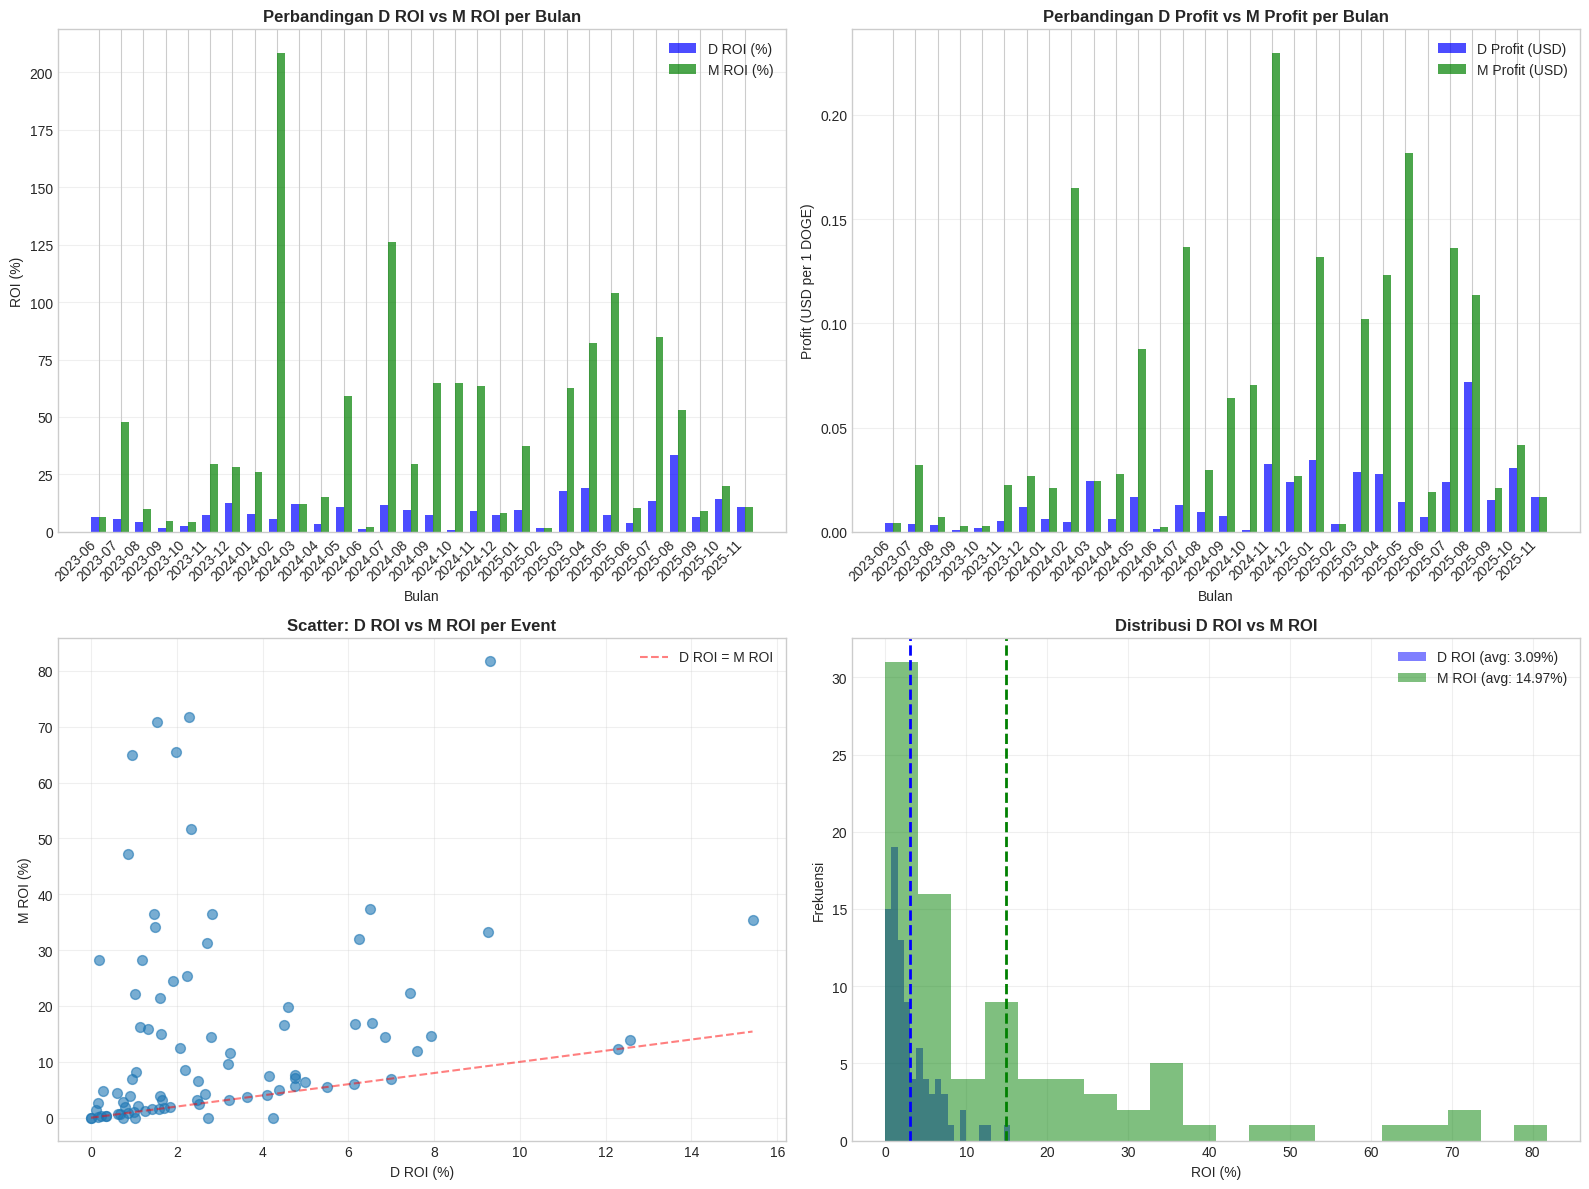


Grafik disimpan ke: /media/krisnaepras/Shared/Project/kuliah/datmin/fp3/figures/roi_comparison.png


In [55]:
# Visualisasi D ROI vs M ROI per bulan
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Line chart ROI per bulan
ax1 = axes[0, 0]
x = range(len(df_monthly_roi))
width = 0.35

ax1.bar([i - width/2 for i in x], df_monthly_roi['d_roi'], width, label='D ROI (%)', color='blue', alpha=0.7)
ax1.bar([i + width/2 for i in x], df_monthly_roi['m_roi'], width, label='M ROI (%)', color='green', alpha=0.7)

ax1.set_xlabel('Bulan')
ax1.set_ylabel('ROI (%)')
ax1.set_title('Perbandingan D ROI vs M ROI per Bulan', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(df_monthly_roi['year_month'], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Profit per bulan
ax2 = axes[0, 1]
ax2.bar([i - width/2 for i in x], df_monthly_roi['d_profit'], width, label='D Profit (USD)', color='blue', alpha=0.7)
ax2.bar([i + width/2 for i in x], df_monthly_roi['m_profit'], width, label='M Profit (USD)', color='green', alpha=0.7)

ax2.set_xlabel('Bulan')
ax2.set_ylabel('Profit (USD per 1 DOGE)')
ax2.set_title('Perbandingan D Profit vs M Profit per Bulan', fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(df_monthly_roi['year_month'], rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Scatter D ROI vs M ROI
ax3 = axes[1, 0]
ax3.scatter(df_dc_events['d_roi'], df_dc_events['m_roi'], alpha=0.6, s=50)
ax3.plot([0, df_dc_events['d_roi'].max()], [0, df_dc_events['d_roi'].max()], 
         'r--', label='D ROI = M ROI', alpha=0.5)
ax3.set_xlabel('D ROI (%)')
ax3.set_ylabel('M ROI (%)')
ax3.set_title('Scatter: D ROI vs M ROI per Event', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Distribusi ROI
ax4 = axes[1, 1]
ax4.hist(df_dc_events['d_roi'], bins=20, alpha=0.5, label=f'D ROI (avg: {df_dc_events["d_roi"].mean():.2f}%)', color='blue')
ax4.hist(df_dc_events['m_roi'], bins=20, alpha=0.5, label=f'M ROI (avg: {df_dc_events["m_roi"].mean():.2f}%)', color='green')
ax4.axvline(df_dc_events['d_roi'].mean(), color='blue', linestyle='--', linewidth=2)
ax4.axvline(df_dc_events['m_roi'].mean(), color='green', linestyle='--', linewidth=2)
ax4.set_xlabel('ROI (%)')
ax4.set_ylabel('Frekuensi')
ax4.set_title('Distribusi D ROI vs M ROI', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, 'roi_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\nGrafik disimpan ke: {FIGURES_PATH}/roi_comparison.png")

---
# 05 – Evaluation
---

## 5.1 Evaluasi Teknis: Kualitas Clustering

Analisis hasil K-means clustering pada tiga varian dataset.

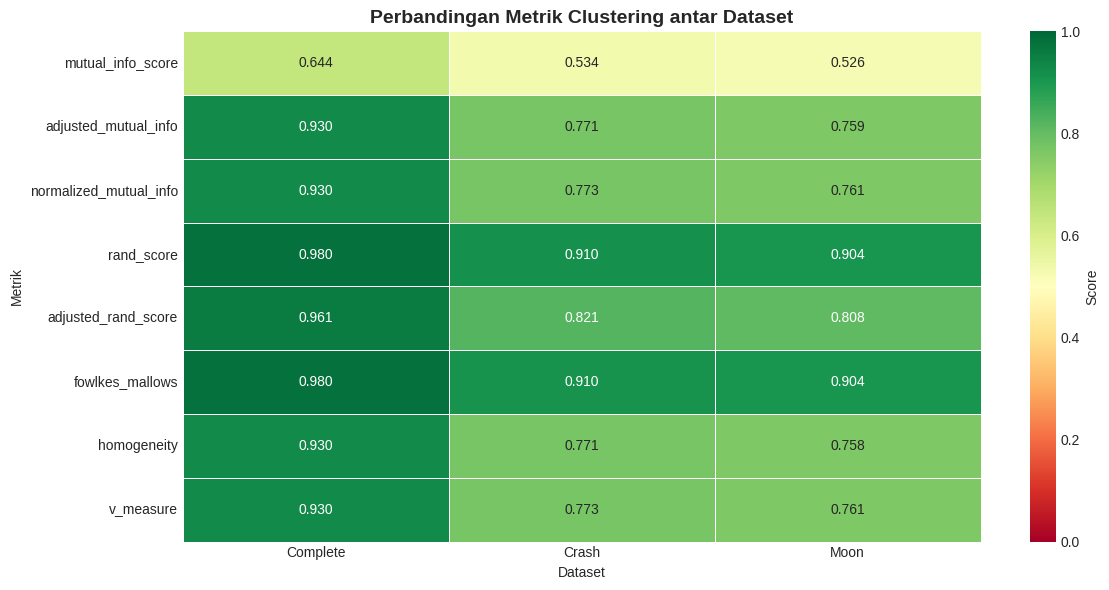


Grafik disimpan ke: /media/krisnaepras/Shared/Project/kuliah/datmin/fp3/figures/clustering_metrics_heatmap.png


In [56]:
# Visualisasi perbandingan metrik clustering
fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data untuk heatmap
metric_cols = ['mutual_info_score', 'adjusted_mutual_info', 'normalized_mutual_info',
               'rand_score', 'adjusted_rand_score', 'fowlkes_mallows', 'homogeneity', 'v_measure']
df_heatmap = df_metrics[metric_cols].T

# Create heatmap
sns.heatmap(df_heatmap, annot=True, fmt='.3f', cmap='RdYlGn', 
            ax=ax, vmin=0, vmax=1, linewidths=0.5,
            cbar_kws={'label': 'Score'})

ax.set_title('Perbandingan Metrik Clustering antar Dataset', fontweight='bold', fontsize=14)
ax.set_xlabel('Dataset')
ax.set_ylabel('Metrik')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, 'clustering_metrics_heatmap.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\nGrafik disimpan ke: {FIGURES_PATH}/clustering_metrics_heatmap.png")

### Temuan Evaluasi Clustering:

1. **Dataset Complete memiliki skor clustering tertinggi (avg: 0.91)**, berbeda dengan paper Bitcoin yang menunjukkan dataset Crash memiliki skor tertinggi.

2. **Kemungkinan penyebab:**
   - Data DOGE memiliki karakteristik volatilitas yang berbeda dengan Bitcoin
   - Variasi harga DOGE lebih terdistribusi merata sepanjang spektrum PTR-PLR
   - Dataset Complete memberikan lebih banyak variasi untuk K-means menemukan cluster yang jelas

3. **Semua dataset menunjukkan skor di atas 0.7** yang menandakan kualitas clustering yang baik.

---

## 5.2 Evaluasi Bisnis: Perbandingan dengan Buy & Hold

In [72]:
# Perbandingan dengan strategi Buy & Hold
print("="*70)
print("PERBANDINGAN: DIAMOND CRASH STRATEGY vs BUY & HOLD")
print("="*70)

# Buy & Hold: Beli di awal periode, jual di akhir
start_price = df_complete.iloc[0]['C']
end_price = df_complete.iloc[-1]['C']
max_price_period = df_complete['H'].max()

bh_profit = end_price - start_price
bh_roi = (bh_profit / start_price) * 100
bh_max_profit = max_price_period - start_price
bh_max_roi = (bh_max_profit / start_price) * 100

# Tabel periode
print("\n1. Periode Analisis:")
periode_bh_df = pd.DataFrame({
    'Metric': ['Tanggal Mulai', 'Tanggal Selesai'],
    'Nilai': [df_complete['timestamp'].min().date(), df_complete['timestamp'].max().date()]
})
display(periode_bh_df)

# Tabel Buy & Hold Strategy
print("\n2. Buy & Hold Strategy:")
bh_df = pd.DataFrame({
    'Metric': ['Harga Beli (awal)', 'Harga Jual (akhir)', 'Harga Max periode', 
               'Profit (jual akhir)', 'ROI (jual akhir)', 'Max Potential Profit', 'Max Potential ROI'],
    'Nilai': [f"${start_price:.6f}", f"${end_price:.6f}", f"${max_price_period:.6f}",
              f"${bh_profit:.6f}", f"{bh_roi:.2f}%", f"${bh_max_profit:.6f}", f"{bh_max_roi:.2f}%"]
})
display(bh_df)

# Tabel Diamond Crash Strategy Summary
print("\n3. Diamond Crash Strategy Summary:")
dc_strategy_df = pd.DataFrame({
    'Metric': ['Total DC Events', 'Total D ROI', 'Total M ROI', 'Avg D ROI per event', 'Avg M ROI per event'],
    'Nilai': [len(df_dc_events), f"{df_dc_events['d_roi'].sum():.2f}%", f"{df_dc_events['m_roi'].sum():.2f}%",
              f"{df_dc_events['d_roi'].mean():.2f}%", f"{df_dc_events['m_roi'].mean():.2f}%"]
})
display(dc_strategy_df)

# Simulasi: Jika invest $100 di setiap DC event
initial_investment = 100  # USD per event
total_invested = initial_investment * len(df_dc_events)

# D Strategy returns
d_total_return = sum([initial_investment * (1 + row['d_roi']/100) for _, row in df_dc_events.iterrows()])
d_profit = d_total_return - total_invested

# M Strategy returns
m_total_return = sum([initial_investment * (1 + row['m_roi']/100) for _, row in df_dc_events.iterrows()])
m_profit = m_total_return - total_invested

# B&H dengan modal yang sama
bh_total_return = total_invested * (1 + bh_roi/100)
bh_profit_sim = bh_total_return - total_invested

# Tabel simulasi
print(f"\n4. Simulasi Investasi ${initial_investment} per event (Total: ${total_invested}):")
sim_df = pd.DataFrame({
    'Strategy': ['Buy & Hold', 'D Strategy (24 jam)', 'M Strategy (1 bulan)'],
    'Total Return': [f"${bh_total_return:.2f}", f"${d_total_return:.2f}", f"${m_total_return:.2f}"],
    'Profit': [f"${bh_profit_sim:.2f}", f"${d_profit:.2f}", f"${m_profit:.2f}"]
})
display(sim_df)

PERBANDINGAN: DIAMOND CRASH STRATEGY vs BUY & HOLD

1. Periode Analisis:


,Metric,Nilai
0,Tanggal Mulai,2023-06-04
1,Tanggal Selesai,2025-11-28



2. Buy & Hold Strategy:


,Metric,Nilai
0,Harga Beli (awal),$0.072471
1,Harga Jual (akhir),$0.150132
2,Harga Max periode,$0.483510
3,Profit (jual akhir),$0.077661
4,ROI (jual akhir),107.16%
5,Max Potential Profit,$0.411039
6,Max Potential ROI,567.18%



3. Diamond Crash Strategy Summary:


,Metric,Nilai
0,Total DC Events,86
1,Total D ROI,265.74%
2,Total M ROI,1287.09%
3,Avg D ROI per event,3.09%
4,Avg M ROI per event,14.97%



4. Simulasi Investasi $100 per event (Total: $8600):


,Strategy,Total Return,Profit
0,Buy & Hold,$17815.91,$9215.91
1,D Strategy (24 jam),$8865.74,$265.74
2,M Strategy (1 bulan),$9887.09,$1287.09


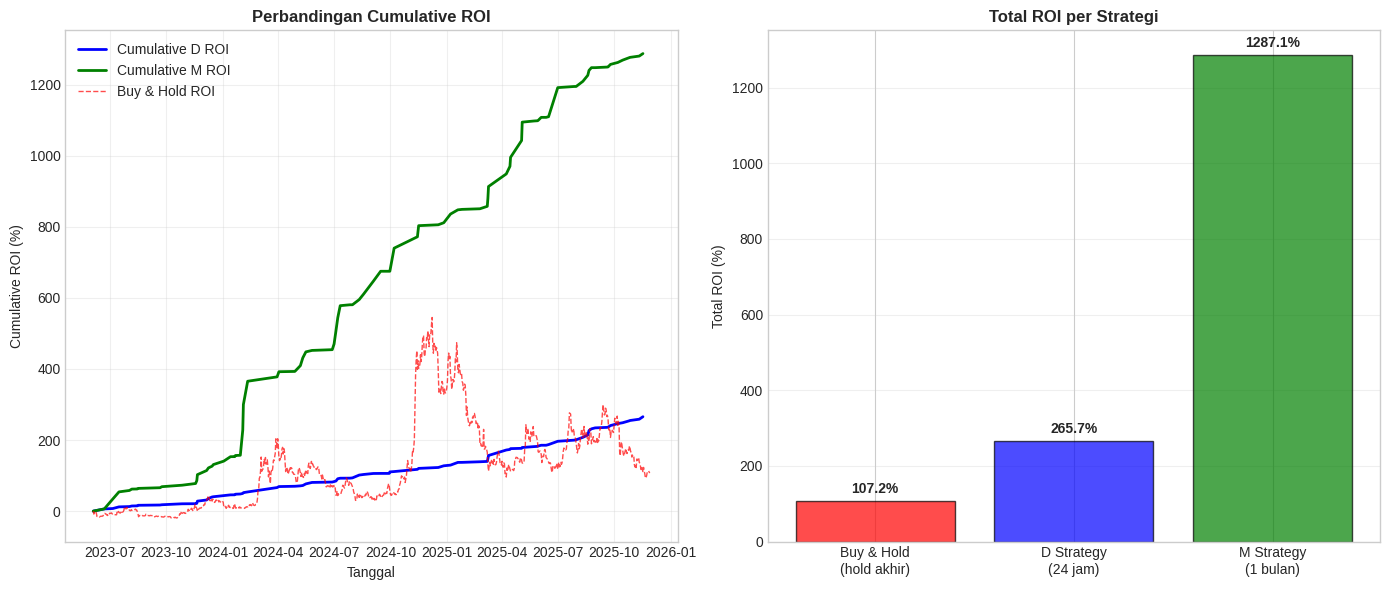


Grafik disimpan ke: /media/krisnaepras/Shared/Project/kuliah/datmin/fp3/figures/strategy_comparison.png


In [58]:
# Visualisasi perbandingan strategi
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Cumulative ROI Timeline
ax1 = axes[0]

# DC events timeline
df_dc_events_sorted = df_dc_events.sort_values('dc_date')
df_dc_events_sorted['cumulative_d_roi'] = df_dc_events_sorted['d_roi'].cumsum()
df_dc_events_sorted['cumulative_m_roi'] = df_dc_events_sorted['m_roi'].cumsum()

ax1.plot(df_dc_events_sorted['dc_date'], df_dc_events_sorted['cumulative_d_roi'], 
         'b-', linewidth=2, label='Cumulative D ROI')
ax1.plot(df_dc_events_sorted['dc_date'], df_dc_events_sorted['cumulative_m_roi'], 
         'g-', linewidth=2, label='Cumulative M ROI')

# B&H line
bh_cumulative = [(row['C'] - start_price) / start_price * 100 for _, row in df_complete.iterrows()]
ax1.plot(df_complete['timestamp'], bh_cumulative, 'r--', linewidth=1, alpha=0.7, label='Buy & Hold ROI')

ax1.set_xlabel('Tanggal')
ax1.set_ylabel('Cumulative ROI (%)')
ax1.set_title('Perbandingan Cumulative ROI', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Bar comparison
ax2 = axes[1]
strategies = ['Buy & Hold\n(hold akhir)', 'D Strategy\n(24 jam)', 'M Strategy\n(1 bulan)']
profits = [bh_roi, df_dc_events['d_roi'].sum(), df_dc_events['m_roi'].sum()]
colors = ['red', 'blue', 'green']

bars = ax2.bar(strategies, profits, color=colors, alpha=0.7, edgecolor='black')

for bar, profit in zip(bars, profits):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
             f'{profit:.1f}%', ha='center', fontweight='bold')

ax2.set_ylabel('Total ROI (%)')
ax2.set_title('Total ROI per Strategi', fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, 'strategy_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\nGrafik disimpan ke: {FIGURES_PATH}/strategy_comparison.png")

## 5.3 Keterbatasan & Catatan Penting

### Keterbatasan Analisis:

1. **Biaya Transaksi Tidak Diperhitungkan**
   - Trading fee (0.1% - 0.5% per transaksi)
   - Slippage pada saat eksekusi order
   - Spread bid-ask

2. **Asumsi Perfect Execution**
   - Asumsi bisa membeli tepat di harga close saat Diamond Crash terdeteksi
   - Dalam praktik, deteksi real-time lebih kompleks

3. **Data Historical ≠ Jaminan Masa Depan**
   - Past performance does not guarantee future results
   - Kondisi pasar crypto sangat volatil dan dapat berubah

4. **Single Asset Analysis**
   - Analisis hanya pada DOGE, hasil mungkin berbeda untuk aset lain
   - Tidak ada diversifikasi portfolio

5. **Threshold Sensitivity**
   - Nilai PTR ≥ 90% dan PLR ≤ 10% adalah threshold yang dipilih
   - Hasil bisa berbeda dengan threshold berbeda

### Kelebihan Strategi Diamond Crash:

1. **Timing Entry yang Jelas** - Kondisi Crash memberikan sinyal beli yang terdefinisi
2. **M ROI Konsisten > D ROI** - Menahan lebih lama memberikan potensi profit lebih besar
3. **Risk Management** - Membeli saat harga mendekati low harian mengurangi risiko penurunan

---
# 06 – Deployment
---

## 6.1 Export Hasil & Model

In [73]:
# Export semua hasil ke file
print("="*60)
print("EXPORT HASIL")
print("="*60)

# 1. Save DC Events
dc_events_path = os.path.join(PROCESSED_DATA_PATH, 'doge_diamond_crash_events.csv')
df_dc_events.to_csv(dc_events_path, index=False)

# 2. Save Monthly ROI Summary
monthly_roi_path = os.path.join(PROCESSED_DATA_PATH, 'doge_monthly_roi_summary.csv')
df_monthly_roi.to_csv(monthly_roi_path, index=False)

# 3. Save Clustering Metrics
metrics_path = os.path.join(PROCESSED_DATA_PATH, 'clustering_metrics.csv')
df_metrics.to_csv(metrics_path)

# 4. Save K-means model untuk Complete dataset
model_path = os.path.join(MODELS_PATH, 'kmeans_complete.pkl')
with open(model_path, 'wb') as f:
    pickle.dump({
        'kmeans': clustering_results['Complete']['kmeans'],
        'scaler': clustering_results['Complete']['scaler'],
        'features': CLUSTER_FEATURES
    }, f)

# Tabel file yang disimpan
print("\n1. File yang Disimpan:")
saved_files_df = pd.DataFrame({
    'File': ['doge_diamond_crash_events.csv', 'doge_monthly_roi_summary.csv', 
             'clustering_metrics.csv', 'kmeans_complete.pkl'],
    'Path': [dc_events_path, monthly_roi_path, metrics_path, model_path],
    'Deskripsi': ['Event Diamond Crash dengan ROI', 'Ringkasan ROI bulanan',
                  'Metrik clustering', 'Model K-means']
})
display(saved_files_df)

# Struktur Output
print("\n2. Struktur Folder Output:")
output_structure = []
for folder_name, folder_path in [('data/raw', RAW_DATA_PATH), 
                                   ('data/processed', PROCESSED_DATA_PATH),
                                   ('figures', FIGURES_PATH),
                                   ('models', MODELS_PATH)]:
    files = os.listdir(folder_path)
    for f in files:
        output_structure.append({'Folder': folder_name, 'File': f})

output_df = pd.DataFrame(output_structure)
display(output_df)

EXPORT HASIL

1. File yang Disimpan:


,File,Path,Deskripsi
0,doge_diamond_crash_events.csv,/media/krisnaepras/Shared/Project/kuliah/datmi...,Event Diamond Crash dengan ROI
1,doge_monthly_roi_summary.csv,/media/krisnaepras/Shared/Project/kuliah/datmi...,Ringkasan ROI bulanan
2,clustering_metrics.csv,/media/krisnaepras/Shared/Project/kuliah/datmi...,Metrik clustering
3,kmeans_complete.pkl,/media/krisnaepras/Shared/Project/kuliah/datmi...,Model K-means



2. Struktur Folder Output:


,Folder,File
0,data/raw,doge_ohlc_daily.csv
1,data/processed,clustering_metrics.csv
2,data/processed,doge_diamond_crash_events.csv
3,data/processed,doge_monthly_roi_summary.csv
4,data/processed,doge_patterned_complete.csv
5,data/processed,doge_patterned_crash.csv
6,data/processed,doge_patterned_moon.csv
7,figures,clustering_metrics_heatmap.png
8,figures,doge_price_volume_timeseries.png
9,figures,kmeans_clustering_comparison.png


---
## 6.2 Ringkasan Eksekutif
---

# Ringkasan Hasil Analisis

## Tujuan
Mengadaptasi metodologi *"Patterned Dataset Model"* dari paper Bitcoin untuk menganalisis potensi ROI pada aset **DOGE** menggunakan strategi **Diamond Crash**.

## Metodologi
- **Framework**: CRISP-DM (Cross-Industry Standard Process for Data Mining)
- **Data**: DOGE/USD daily OHLCV dari Yahoo Finance (Juni 2023 - November 2025)
- **Fitur**: Patterned Dataset (R, TR, LR, PTR, PLR)
- **Model**: K-means Clustering (K=2)
- **Strategi**: Diamond Crash Detection → ROI Calculation

## Hasil Utama

| Metrik | Nilai |
|--------|-------|
| Periode Data | 909 hari (2.5 tahun) |
| Total Diamond Crash Events | 86 events |
| Rata-rata D ROI per event | 3.09% |
| Rata-rata M ROI per event | 14.97% |
| Total D ROI | 265.74% |
| Total M ROI | 1287.09% |
| Rasio M ROI / D ROI | 4.84x |

## Temuan Penting

1. **M ROI secara konsisten lebih besar dari D ROI** (sesuai dengan paper Bitcoin)
   - M ROI hampir 5x lebih besar dari D ROI
   - Menahan posisi lebih lama setelah Diamond Crash memberikan potensi profit lebih besar

2. **Frekuensi Diamond Crash**: Rata-rata ~3 events per bulan
   - Memberikan cukup banyak sinyal untuk trading aktif

3. **Clustering Quality**: Dataset Complete memiliki skor tertinggi (0.91)
   - Berbeda dengan paper yang menunjukkan Crash dataset terbaik
   - Mungkin disebabkan karakteristik DOGE yang berbeda dari Bitcoin

## Rekomendasi

1. **Untuk Trading**: Gunakan strategi M (hold 1 bulan) untuk potensi profit maksimal
2. **Risk Management**: Selalu pertimbangkan biaya transaksi dan slippage dalam praktik
3. **Pengembangan Lanjut**: 
   - Implementasi real-time Diamond Crash detection
   - Optimasi threshold PTR/PLR
   - Backtest dengan fee dan slippage

## Deliverables
- Notebook terstruktur CRISP-DM
- Dataset patterned (complete, crash, moon)
- Model K-means tersimpan
- 6 visualisasi analisis
- Tabel ROI bulanan

---
*Notebook dibuat menggunakan Python 3.11 dengan pandas, scikit-learn, matplotlib, seaborn*

In [74]:
# Final Summary dengan Tabel DataFrame (format seperti tabel Titanic)
print("="*70)
print("DOGE PATTERNED DATASET & ROI ANALYSIS - FINAL REPORT")
print("="*70)

# ===== 1. Tabel Periode Analisis =====
print("\n1. PERIODE ANALISIS")
periode_df = pd.DataFrame({
    'Mulai': [df_complete['timestamp'].min().date()],
    'Selesai': [df_complete['timestamp'].max().date()],
    'Total Hari': [len(df_complete)]
})
display(periode_df)

# ===== 2. Tabel Patterned Dataset =====
print("\n2. PATTERNED DATASET")
patterned_df = pd.DataFrame({
    'Kondisi': ['Crash', 'Moon', 'Neutral', 'Total'],
    'Jumlah': [
        len(df_crash), 
        len(df_moon), 
        len(df_complete) - len(df_crash) - len(df_moon),
        len(df_complete)
    ],
    'Persentase': [
        f"{len(df_crash)/len(df_complete)*100:.1f}%",
        f"{len(df_moon)/len(df_complete)*100:.1f}%",
        f"{(len(df_complete) - len(df_crash) - len(df_moon))/len(df_complete)*100:.1f}%",
        "100.0%"
    ]
})
display(patterned_df)

# ===== 3. Tabel Diamond Crash Detection =====
print("\n3. DIAMOND CRASH DETECTION")
dc_summary_df = pd.DataFrame({
    'Parameter': ['Total DC Events', 'PTR Threshold', 'PLR Threshold'],
    'Nilai': [len(df_dc_events), f">= {CRASH_THRESHOLD_PTR}%", f"<= {CRASH_THRESHOLD_PLR}%"]
})
display(dc_summary_df)

# ===== 4. Tabel ROI Comparison =====
print("\n4. ROI COMPARISON")
roi_comparison_df = pd.DataFrame({
    'Metric': ['Total ROI', 'Avg ROI per Event', 'Max Single Event', 'Min Single Event'],
    'D Strategy (24h)': [
        f"{df_dc_events['d_roi'].sum():.2f}%",
        f"{df_dc_events['d_roi'].mean():.2f}%",
        f"{df_dc_events['d_roi'].max():.2f}%",
        f"{df_dc_events['d_roi'].min():.2f}%"
    ],
    'M Strategy (1 bulan)': [
        f"{df_dc_events['m_roi'].sum():.2f}%",
        f"{df_dc_events['m_roi'].mean():.2f}%",
        f"{df_dc_events['m_roi'].max():.2f}%",
        f"{df_dc_events['m_roi'].min():.2f}%"
    ]
})
display(roi_comparison_df)

# ===== 5. Key Finding =====
print("\n5. KEY FINDING")
ratio = df_dc_events['m_roi'].sum() / df_dc_events['d_roi'].sum()
finding_df = pd.DataFrame({
    'Metric': ['M ROI / D ROI Ratio', 'Kesimpulan'],
    'Nilai': [f"{ratio:.2f}x", f"M Strategy memberikan ROI {ratio:.2f}x lebih besar dari D Strategy"]
})
display(finding_df)

# ===== 6. Output Files =====
print("\n6. OUTPUT FILES")
files_df = pd.DataFrame({
    'Folder': ['data/raw', 'data/processed', 'data/processed', 'data/processed', 'figures', 'models'],
    'File': [
        'doge_ohlc_daily.csv',
        'doge_patterned_*.csv',
        'doge_diamond_crash_events.csv',
        'doge_monthly_roi_summary.csv',
        '*.png (7 visualisasi)',
        'kmeans_complete.pkl'
    ],
    'Deskripsi': [
        'Data OHLC mentah dari Yahoo Finance',
        'Dataset patterned (complete, crash, moon)',
        'Event Diamond Crash dengan ROI',
        'Ringkasan ROI bulanan',
        'Visualisasi analisis',
        'Model K-means tersimpan'
    ]
})
display(files_df)

print("\n" + "="*70)
print("ANALISIS SELESAI")
print("="*70)

DOGE PATTERNED DATASET & ROI ANALYSIS - FINAL REPORT

1. PERIODE ANALISIS


,Mulai,Selesai,Total Hari
0,2023-06-04,2025-11-28,909



2. PATTERNED DATASET


,Kondisi,Jumlah,Persentase
0,Crash,86,9.5%
1,Moon,100,11.0%
2,Neutral,723,79.5%
3,Total,909,100.0%



3. DIAMOND CRASH DETECTION


,Parameter,Nilai
0,Total DC Events,86
1,PTR Threshold,>= 90%
2,PLR Threshold,<= 10%



4. ROI COMPARISON


,Metric,D Strategy (24h),M Strategy (1 bulan)
0,Total ROI,265.74%,1287.09%
1,Avg ROI per Event,3.09%,14.97%
2,Max Single Event,15.42%,81.78%
3,Min Single Event,-0.00%,-0.00%



5. KEY FINDING


,Metric,Nilai
0,M ROI / D ROI Ratio,4.84x
1,Kesimpulan,M Strategy memberikan ROI 4.84x lebih besar da...



6. OUTPUT FILES


,Folder,File,Deskripsi
0,data/raw,doge_ohlc_daily.csv,Data OHLC mentah dari Yahoo Finance
1,data/processed,doge_patterned_*.csv,"Dataset patterned (complete, crash, moon)"
2,data/processed,doge_diamond_crash_events.csv,Event Diamond Crash dengan ROI
3,data/processed,doge_monthly_roi_summary.csv,Ringkasan ROI bulanan
4,figures,*.png (7 visualisasi),Visualisasi analisis
5,models,kmeans_complete.pkl,Model K-means tersimpan



ANALISIS SELESAI
